In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


### Split Data Train dan Validasi

In [23]:
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_dir = "/content/drive/MyDrive/Tubes DL"
train_dir = "/content/drive/MyDrive/dataset tubes/train"
valid_dir = "/content/drive/MyDrive/dataset tubes/valid"

# Membuat folder train dan valid jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)


In [7]:
# Membaca semua subfolder (misalnya 'normal', 'abnormal')
categories = os.listdir(data_dir)

# Memproses setiap kategori (subfolder)
for category in categories:
    category_path = os.path.join(data_dir, category)

    # Cek jika itu adalah direktori (bukan file)
    if os.path.isdir(category_path):
        # Membaca semua gambar dalam kategori
        all_images = os.listdir(category_path)

        # Membagi data menjadi train dan valid (80%-20%)
        train_images, valid_images = train_test_split(all_images, test_size=0.2, random_state=42)

        # Membuat subfolder untuk kategori di dalam folder train dan valid
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(valid_dir, category), exist_ok=True)

        # Menyalin file ke folder train dan valid
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))

        for img in valid_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(valid_dir, category, img))

        print(f"Folder '{category}' berhasil dibagi menjadi train dan valid.")

Folder 'abnormal' berhasil dibagi menjadi train dan valid.
Folder 'normal' berhasil dibagi menjadi train dan valid.


In [10]:
import os
def count_files(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len(files)
    return total

print(f"Train Normal: {count_files(os.path.join(train_dir, 'normal'))}")
print(f"Train Abnormal: {count_files(os.path.join(train_dir, 'abnormal'))}")
print(f"Valid Normal: {count_files(os.path.join(valid_dir, 'normal'))}")
print(f"Valid Abnormal: {count_files(os.path.join(valid_dir, 'abnormal'))}")


Train Normal: 160
Train Abnormal: 160
Valid Normal: 40
Valid Abnormal: 40


### Import Libraries

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize


### Setting dataset Path & Hyperparameters

In [12]:
# Path ke dataset
train_dir = "/content/drive/MyDrive/dataset tubes/train"
valid_dir = "/content/drive/MyDrive/dataset tubes/valid"

# Ukuran gambar dan batch size
img_height, img_width = 224, 224  # Meningkatkan ukuran gambar
batch_size = 32  # Mengurangi batch size untuk stabilitas pelatihan

### Data Preprocessing & Augmentasi

In [13]:
# ImageDataGenerator untuk training dan validasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Mengurangi rotation range
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,  # Mengurangi shear range
    zoom_range=0.1,   # Mengurangi zoom range
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Data training
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',  # Menggunakan RGB
    class_mode='binary'
)

# Data validasi
val_data = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',  # Menggunakan RGB
    class_mode='binary'
)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


### Membangun Model

In [29]:
# Menggunakan VGG16 sebagai base model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Pre-trained weights dari ImageNet
    include_top=False,   # Menghapus fully connected layer terakhir
    input_shape=(img_height, img_width, 3)  # Input shape untuk RGB
)

# Membekukan beberapa layer terakhir dari base model untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-2]:  # Membekukan lebih sedikit layer
    layer.trainable = False

# Menambahkan fully connected layers di atas base model
model = models.Sequential([
    base_model,
    layers.Flatten(),  # Flatten output convolusi
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Mengurangi dropout
    layers.Dense(1, activation='sigmoid')  # Output layer untuk binary classification
])

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Learning rate yang sedikit lebih tinggi
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 5,571,329 (21.25 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

### Call & Training

In [15]:
# Callback EarlyStopping untuk menghentikan pelatihan jika tidak ada perbaikan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model dengan data augmentation tanpa workers
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Meningkatkan jumlah epochs
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5417 - loss: 0.8091 - val_accuracy: 0.6250 - val_loss: 0.5974
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 654ms/step - accuracy: 0.7326 - loss: 0.5537 - val_accuracy: 0.9250 - val_loss: 0.4428
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 685ms/step - accuracy: 0.8132 - loss: 0.4425 - val_accuracy: 0.9000 - val_loss: 0.3263
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.8544 - loss: 0.3422 - val_accuracy: 0.9375 - val_loss: 0.2725
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 682ms/step - accuracy: 0.8799 - loss: 0.3019 - val_accuracy: 0.7500 - val_loss: 0.5092
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.8065 - loss: 0.3626 - val_accuracy: 0.7500 - val_loss: 0.4394
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 548ms/step - accuracy: 0.8825 - loss: 0.2528 - val_accuracy: 0.8500 - val_loss: 0.3400
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 631ms/step - accuracy: 0.8673 - loss: 0.2740 - val_accuracy: 0.9375 -

### Plot Hitory Training

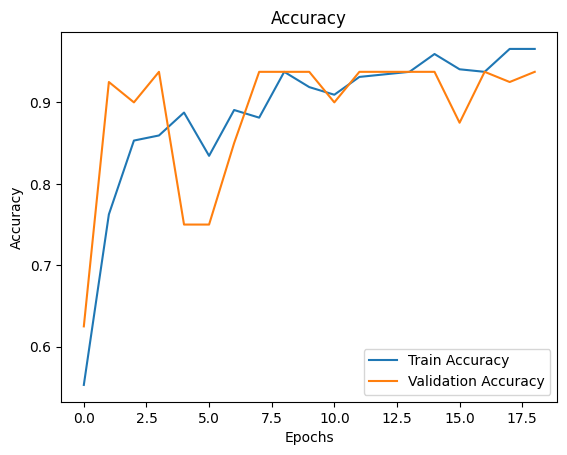

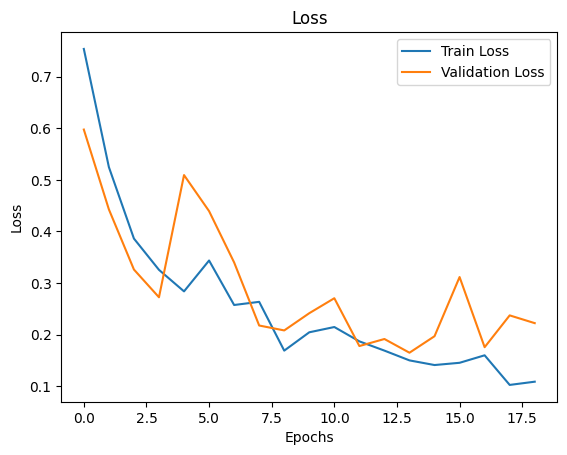

In [16]:
# Visualisasi akurasi dan loss selama pelatihan
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluasi Model Data Validasi

In [17]:
# Evaluasi model pada data validasi
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step - accuracy: 0.9375 - loss: 0.1424
Validation Accuracy: 0.94
Validation Loss: 0.17


### Model Evaluasi Pada Data Test

In [18]:
# Path ke dataset uji
test_dir = "/content/drive/MyDrive/dataset tubes/test"

# Menyiapkan data uji dengan rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Memuat data uji
test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),  # Ukuran gambar yang sama dengan yang digunakan untuk pelatihan
    batch_size=batch_size,
    color_mode='rgb',  # Menggunakan mode warna RGB
    class_mode='binary',  # Untuk klasifikasi biner
    shuffle=False  # Jangan acak data agar urutannya tetap
)

# Prediksi model pada data uji
predictions = model.predict(test_data, verbose=1)

# Mengonversi prediksi ke label biner (0 atau 1) dengan threshold 0.5
predicted_labels = (predictions > 0.5).astype("int32")

# Mengambil label asli dari data uji
true_labels = test_data.classes


Found 60 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 14s/step


### Confusion Matrix & Klafikasi Report

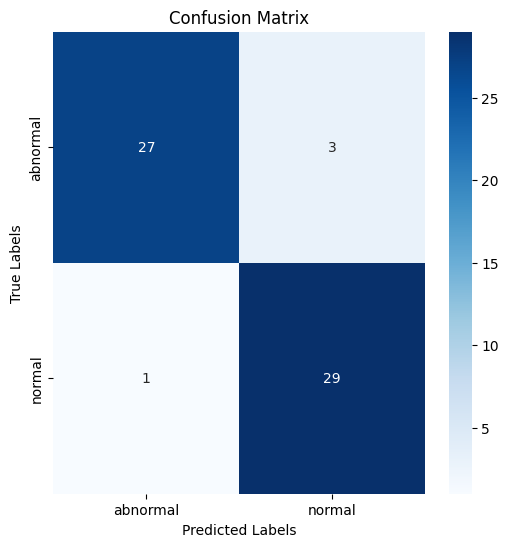

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.91      0.97      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



In [28]:
# Menghitung matriks kebingunguan
cm = confusion_matrix(true_labels, predicted_labels)

# Visualisasi matriks kebingunguan
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

### Evaluasi Model dengan ROC AUC

In [20]:
# Menghitung ROC AUC Score
# Prediksi probabilitas untuk kelas positif (label 1)
predicted_probs = model.predict(test_data, verbose=1)

# Menggunakan label biner untuk ROC AUC
# Jika dataset adalah binary, kita cukup menggunakan predicted_probs untuk kelas 1
roc_auc = roc_auc_score(true_labels, predicted_probs)

print(f"ROC AUC Score: {roc_auc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 952ms/step
ROC AUC Score: 0.9811


### Plot Kurva ROC

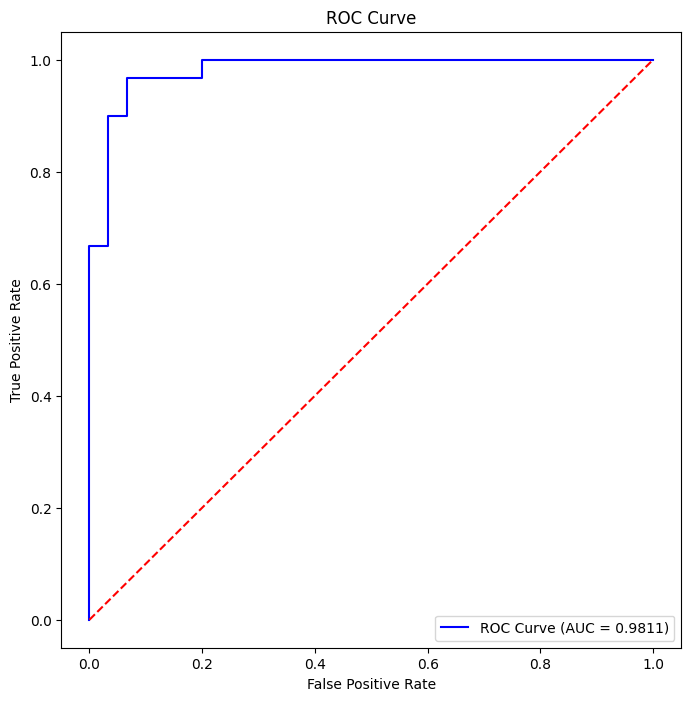

In [21]:
# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Visualisasi ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()